In [1]:
import pandas as pd
import numpy as np
from env import get_db_url
import evaluate, split_scale
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.formula.api import ols
from math import sqrt

# Data acquisition

In [2]:
url = get_db_url('zillow')
query = ('''
SELECT bathroomcnt AS bathroom, bedroomcnt AS bedroom, 
    calculatedfinishedsquarefeet AS square_feet, taxamount AS tax, 
    fips AS county, taxvaluedollarcnt AS house_value 
FROM properties_2017
WHERE propertylandusetypeid = 261
''')
df_orig = pd.read_sql(query, url)

In [3]:
counties = pd.read_table('FIPS.txt', header=1)
counties.columns = ['FIPS', 'county', 'state']
counties.head()

,FIPS,county,state
0,1001,Autauga,AL
1,1003,Baldwin,AL
2,1005,Barbour,AL
3,1007,Bibb,AL
4,1009,Blount,AL


# Data Preparation

In [4]:
df = df_orig.copy()
df.head(10)

,bathroom,bedroom,square_feet,tax,county,house_value
0,0.0,0.0,NaN,NaN,6037.0,27516.0
1,0.0,0.0,NaN,NaN,6037.0,10.0
2,0.0,0.0,NaN,NaN,6037.0,10.0
3,0.0,0.0,NaN,174.21,6037.0,2108.0
4,2.0,4.0,3633.0,6941.39,6037.0,296425.0
5,0.0,0.0,NaN,NaN,6037.0,124.0
6,4.0,3.0,1620.0,10244.94,6037.0,847770.0
7,2.0,3.0,2077.0,7924.68,6037.0,646760.0
8,0.0,0.0,NaN,80348.13,6037.0,6730242.0
9,0.0,0.0,NaN,248.89,6037.0,15532.0


In [5]:
df.isnull().sum()

bathroom         11
bedroom          11
square_feet    8484
tax            4442
county            0
house_value     493
dtype: int64

In [6]:
df.shape[0]

2152863

In [7]:
bathroom_std = df.bathroom.std()
bedroom_std = df.bedroom.std()
square_feet_std = df.square_feet.std()
house_value_std = df.house_value.std()

df.bedroom = df.bedroom[(df.bedroom <= bedroom_std * 10)]
df.bathroom = df.bathroom[(df.bathroom <= bathroom_std * 10)]
df.square_feet = df.square_feet[
    (df.square_feet <= square_feet_std * 10) &
    (df.square_feet >= square_feet_std * .1)]
df.house_value = df.house_value[
    (df.house_value <= house_value_std * 10) & 
    (df.house_value >= house_value_std * .1)]

In [10]:
ave_bedrooms = round(df.bedroom.mean())
df.bedroom.replace(0, ave_bedrooms, inplace=True)

ave_bathrooms = round(df.bathroom.mean())
df.bathroom.replace(0, ave_bathrooms, inplace=True)

In [11]:
df.isnull().sum()

bathroom          690
bedroom           213
square_feet      9330
tax              4442
county              0
house_value    146729
dtype: int64

This is how many data points I found to be extreme outliers, and so removed

In [12]:
df.dropna(inplace=True)
df.shape[0]

1998878

In [13]:
df.county = df.county.astype(int)
df.square_feet = df.square_feet.astype(int)
df.bedroom = df.bedroom.astype(int)
df.house_value = df.house_value.astype(int)

In [14]:
df.head()

,bathroom,bedroom,square_feet,tax,county,house_value
4,2.0,4,3633,6941.39,6037,296425
6,4.0,3,1620,10244.94,6037,847770
7,2.0,3,2077,7924.68,6037,646760
18,1.0,3,1244,2532.88,6037,169471
19,2.0,3,1300,3110.99,6037,233266


In [15]:
df = pd.merge(df, counties, left_on='county', 
             right_on='FIPS', how='left')
df.drop(columns='county_x', inplace=True)

In [16]:
df.columns = ['bathroom', 'bedroom', 'square_feet', 'tax', 
              'house_value', 'FIPS', 'county', 'state']
df.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
0,2.0,4,3633,6941.39,296425,6037,Los Angeles,CA
1,4.0,3,1620,10244.94,847770,6037,Los Angeles,CA
2,2.0,3,2077,7924.68,646760,6037,Los Angeles,CA
3,1.0,3,1244,2532.88,169471,6037,Los Angeles,CA
4,2.0,3,1300,3110.99,233266,6037,Los Angeles,CA


# Data exploration

In [17]:
train, test = split_scale.split_my_data(df, .8)
train.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
520471,2.0,4,2563,4959.66,388653,6037,Los Angeles,CA
268059,3.5,4,3938,9855.16,814611,6059,Orange,CA
1085911,2.0,3,1222,4007.08,312261,6037,Los Angeles,CA
247538,2.0,4,1461,5227.42,443180,6059,Orange,CA
818115,2.5,4,1951,2054.18,157102,6059,Orange,CA


## Null Hypothesis:
##### There is no correlation between bedroom or bathroom count being low (less than 4) and house value

In [18]:
x = train[(train.bedroom < 4)].house_value
mu = train.house_value.mean()
t_stat, p = stats.ttest_1samp(x, mu)
t_stat, p

(-242.79648331619097, 0.0)

In [19]:
x = train[(train.bathroom < 4)].house_value

mu = train.house_value.mean()
t_stat, p = stats.ttest_1samp(x, mu)
t_stat, p

(-259.27290680188867, 0.0)

These t statistics being so far away from 0 is a very strong indication that we should discard the null hypothesis

In [20]:
r, p = stats.pearsonr(train.bathroom, train.house_value)
r, p

(0.5405525325690361, 0.0)

This high r value indicates a high correlation between bathroom count and house value

In [21]:
r, p = stats.pearsonr(train.bedroom, train.house_value)
r, p

(0.27175872576859433, 0.0)

This relatively small r value indicates that there is a moderate correlation between bedroom count and house value

In [22]:
r, p = stats.pearsonr(train.square_feet, train.house_value)
r, p

(0.6241016649948822, 0.0)

This high r value indicates a very high correlation between square footage and house value

In [69]:
train.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
520471,2.000,4,2563,4959.660,388653,6037,Los Angeles,CA
268059,3.500,4,3938,9855.160,814611,6059,Orange,CA
1085911,2.000,3,1222,4007.080,312261,6037,Los Angeles,CA
247538,2.000,4,1461,5227.420,443180,6059,Orange,CA
818115,2.500,4,1951,2054.180,157102,6059,Orange,CA


In [23]:
train2 = train.copy()
train2.drop(columns=['county', 'tax', 'state', 'FIPS'], inplace=True)
sns.pairplot(train2)

In [24]:
sns.lmplot('bathroom', 'bedroom', train)

This graph implies a likely correlation between bedroom and bathroom, so it might be best to not use both in predicting house value

In [25]:
train.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
520471,2.0,4,2563,4959.66,388653,6037,Los Angeles,CA
268059,3.5,4,3938,9855.16,814611,6059,Orange,CA
1085911,2.0,3,1222,4007.08,312261,6037,Los Angeles,CA
247538,2.0,4,1461,5227.42,443180,6059,Orange,CA
818115,2.5,4,1951,2054.18,157102,6059,Orange,CA


# Feature engineering and Modeling

In [26]:
X_train = train[['bathroom', 'bedroom', 'square_feet']]
y_train = train.house_value

In [71]:
selector = SelectKBest(f_regression, k=2)
selector.fit(X_train, y_train)
X2 = selector.transform(X_train)

support = selector.get_support()
X_train.columns[support].tolist()

['bathroom', 'square_feet']

In [70]:
rfe = RFE(LinearRegression(), 2)
X_rfe = rfe.fit_transform(X_train, y_train)
mask = rfe.support_
X_train.columns[mask].tolist()

['bathroom', 'bedroom']

In [29]:
predictions = pd.DataFrame({'actual': train.house_value})
predictions.head()

,actual
520471,388653
268059,814611
1085911,312261
247538,443180
818115,157102


In [30]:
predictions['base_average'] = train.house_value.mean()
predictions.base_average = predictions.base_average.astype(int)
predictions.head()

,actual,base_average
520471,388653,472530
268059,814611,472530
1085911,312261,472530
247538,443180,472530
818115,157102,472530


In [31]:
#Using all 3 features
simple_lm_all = LinearRegression()
simple_lm_all.fit(X_train, y_train)
predictions['simple_lm_all'] = simple_lm_all.predict(X_train)
predictions.simple_lm_all = predictions.simple_lm_all.astype(int)
predictions.head()

,actual,base_average,simple_lm_all
520471,388653,472530,606071
268059,814611,472530,1177623
1085911,312261,472530,260519
247538,443180,472530,232111
818115,157102,472530,433374


In [76]:
# Using the two features suggested by SelectKBest
X = train[['bathroom', 'square_feet']]

simple_lm_2 = LinearRegression()
simple_lm_2.fit(X, y_train)
predictions['simple_lm_kbest'] = simple_lm_2.predict(X)
predictions.simple_lm_kbest = predictions.simple_lm_kbest.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_kbest,rfe,poly
520471,388653,472530,606071,670494,340663,567166
268059,814611,472530,1177623,1138209,811352,1139139
1085911,312261,472530,260519,255911,403740,257194
247538,443180,472530,232111,329800,340663,215824
818115,157102,472530,433374,495495,497559,416577


In [78]:
X_test

,bathroom,bedroom,square_feet
1794013,3.000,4,2394
1021584,4.000,4,2877
54709,2.000,3,1626
1561339,2.000,3,1675
1217948,2.000,4,1752
...,...,...,...
1093784,2.000,3,1935
1571089,3.000,4,2330
594840,2.000,3,1424
1676217,1.500,3,1272


In [33]:
lm_rfe = LinearRegression()
rfe_use = RFE(lm_rfe, 2)
rfe_use.fit(X_train, y_train)
X_rfe = rfe_use.transform(X_train)
lm_rfe.fit(X_rfe, y_train)

predictions['rfe'] = lm_rfe.predict(X_rfe)
predictions.rfe = predictions.rfe.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_kbest,rfe
520471,388653,472530,606071,670494,340663
268059,814611,472530,1177623,1138209,811352
1085911,312261,472530,260519,255911,403740
247538,443180,472530,232111,329800,340663
818115,157102,472530,433374,495495,497559


These numbers would certainly be better if I replaced the 0s of bedroom and bathroom with a weighted average based on square feet rather than a fixed average.

In [61]:
poly = PolynomialFeatures(degree=3, interaction_only=True, 
                              include_bias=False)
poly.fit(X_train)
X_poly = pd.DataFrame(poly.transform(X_train), 
                    columns=poly.get_feature_names(X_train.columns))

lm = LinearRegression()
rfe = RFE(lm, 4)
rfe.fit(X_poly, y_train)
X_rfe = pd.DataFrame(rfe.transform(X_poly), 
                         columns=X_poly.columns[rfe.support_])
X_rfe

,bathroom,bedroom,square_feet,bathroom bedroom
0,2.000,4.000,2563.000,8.000
1,3.500,4.000,3938.000,14.000
2,2.000,3.000,1222.000,6.000
3,2.000,4.000,1461.000,8.000
4,2.500,4.000,1951.000,10.000
...,...,...,...,...
1599097,3.000,4.000,1424.000,12.000
1599098,1.000,1.000,593.000,1.000
1599099,3.000,4.000,3232.000,12.000
1599100,2.000,4.000,1703.000,8.000


In [48]:
lm_poly = LinearRegression().fit(X_rfe, y_train)
predictions['poly'] = lm_poly.predict(X_rfe)
predictions.poly = predictions.poly.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_kbest,rfe,poly
520471,388653,472530,606071,670494,340663,567166
268059,814611,472530,1177623,1138209,811352,1139139
1085911,312261,472530,260519,255911,403740,257194
247538,443180,472530,232111,329800,340663,215824
818115,157102,472530,433374,495495,497559,416577


In [36]:
evaluate.better_than_baseline(y_train, predictions.simple_lm_all)

True: 100213345577.59 is greater than 0


In [49]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda c: sqrt(mse(predictions.actual, c)))

actual                 0.000
base_average      491815.972
simple_lm_all     376390.229
simple_lm_kbest   383989.633
rfe               411355.424
poly              373425.166
dtype: float64

With an RMSE of 476,204 on the baseline model, it is clear that all 4 other models do better because their RMSEs are lower, with polynomial having the lowest. Therefore, we will be using polynomial as our final model.

# Final model and Evaluation

In [63]:
X_test = test[['bathroom', 'bedroom', 'square_feet']]
y_test = test.house_value
X_test.head()

,bathroom,bedroom,square_feet
1794013,3.000,4,2394
1021584,4.000,4,2877
54709,2.000,3,1626
1561339,2.000,3,1675
1217948,2.000,4,1752


In [57]:
X_test_poly = poly.transform(X_test)
X_test_rfe = rfe.transform(X_test_poly)
y_test_predictions_poly = lm_poly.predict(X_test_rfe)

poly_rmse = sqrt(mse(y_test, y_test_predictions_poly))
poly_rmse

373297.0418056595

In [80]:
y_test_predictions_k2 = simple_lm_2.predict(X_test.drop(columns='bedroom'))

k2_rmse = sqrt(mse(y_test, y_test_predictions_k2))
k2_rmse

383893.9150386548

In [62]:
model = ols('y_test ~ X_test', data=test).fit()
r2, p = evaluate.model_significance(model)
r2, p

(0.4155221814285004, 0.0)

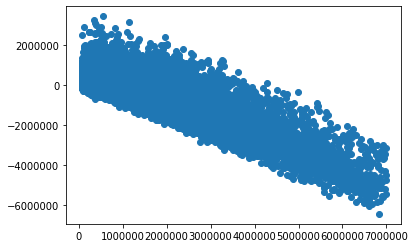

In [58]:
evaluate.plot_residuals(y_test, y_test_predictions_poly)

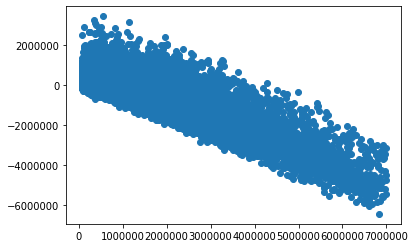

In [81]:
evaluate.plot_residuals(y_test, y_test_predictions_poly)

- Using the model that had the lowest RMSE, polynomial, I predicted the test values, and got an RMSE that is almost exactly the same sitting at 373k. 
- Using an ols model my test data resulted in an r2 statistic of .416, showing that a large portion of the variance can be explained by the data.
- Finally, a plot of the residuals shows that because there is a discernable pattern, there is liekly more to this data that might be extracted at a later time, or rather it would likely be better to use a nonlinear model to predict this data.
- With all of these factors taken into account, I can comfortably call this a useable model.

# Tax distributions

In [66]:
df['tax_rate'] = df.tax / df.house_value
df.groupby('county').tax_rate.mean()

county
Los Angeles   0.013
Orange        0.012
Ventura       0.012
Name: tax_rate, dtype: float64